In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Data processing
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.blocks import StdLinear, DenseBlock
from utils.clr import *
from collections import OrderedDict

In [2]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Model vars
bs = 1

False


## Data Injest

In [3]:
PATH = "../notebooks/data/dual_sen_sample_1.csv"

In [74]:
def moving_mean(time, data, lag=5):
    X = []
    y = []
    y_std = []
    for i in range(int(len(data)/lag)):
        X.append(time[(i*lag+lag)])
        y.append(np.mean(data[(i*lag):(i*lag+lag)]))
        y_std.append(np.std(data[(i*lag):(i*lag+lag)]))
        
    return X, y, y_std

In [75]:
df = pd.read_csv(PATH,parse_dates=['datetime','date'])

df.drop(['date','time','r_sen_1','s_sen_1','s_sen_2'],axis=1,inplace=True)
# df["mvg20_sen_2"] = df.loc[:,"r_sen_2"].rolling(window=20).mean()
# df["mvg20_sen_2"] = df["mvg20_sen_2"].round()
df['r_sen_2'] = (df['r_sen_2'] - 630)*-1
x, y, y_err = moving_mean(df['datetime'],df["r_sen_2"], 10)
df.loc[df['datetime'].isin(x),'avg_sen_2'] = y
df.loc[df['datetime'].isin(x),'std_sen_2'] = y_err
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

df.to_feather('../notebooks/data/sen_aggre.feather')
df.head()

,datetime,r_sen_2,avg_sen_2,std_sen_2
0,2020-08-12 15:02:11,0,0.0,0.0
1,2020-08-12 15:12:11,0,0.0,0.0
2,2020-08-12 15:22:11,0,0.0,0.0
3,2020-08-12 15:32:11,0,0.0,0.0
4,2020-08-12 15:42:11,0,0.0,0.0


## Data visual

In [76]:
df_w = df.loc[df['std_sen_2'] > 15]
df_t = pd.DataFrame(data={'datetime':pd.to_datetime("2020-08-07 13:40:31"),'r_sen_2':np.average(df_w['r_sen_2']), 'avg_sen_2':np.average(df_w['avg_sen_2']),'std_sen_2':np.average(df_w['std_sen_2'])},index=[0])
df_t = df_t.append(df_w)
df_t.sort_values(['datetime'],ascending=False,inplace=True)


for r_i, r_d in df.iterrows():
    for idx, row in df_t.iterrows():
        if r_d.datetime >= row.datetime:
            df.loc[r_i,'last_water'] = r_d.datetime - row.datetime
            break
        else:
            next

df['dow'] = df.datetime.dt.dayofweek
df.reset_index(inplace=True)
df.index = df.datetime
df.drop("datetime",axis=1,inplace=True)
df.dropna(inplace=True)
df_w

,datetime,r_sen_2,avg_sen_2,std_sen_2
597,2020-08-16 18:28:31,202,112.6,113.558091
2152,2020-08-27 13:27:31,154,184.0,23.383755
3572,2020-09-06 10:01:53,210,113.6,114.248151
4738,2020-09-14 12:13:49,251,29.9,89.700000


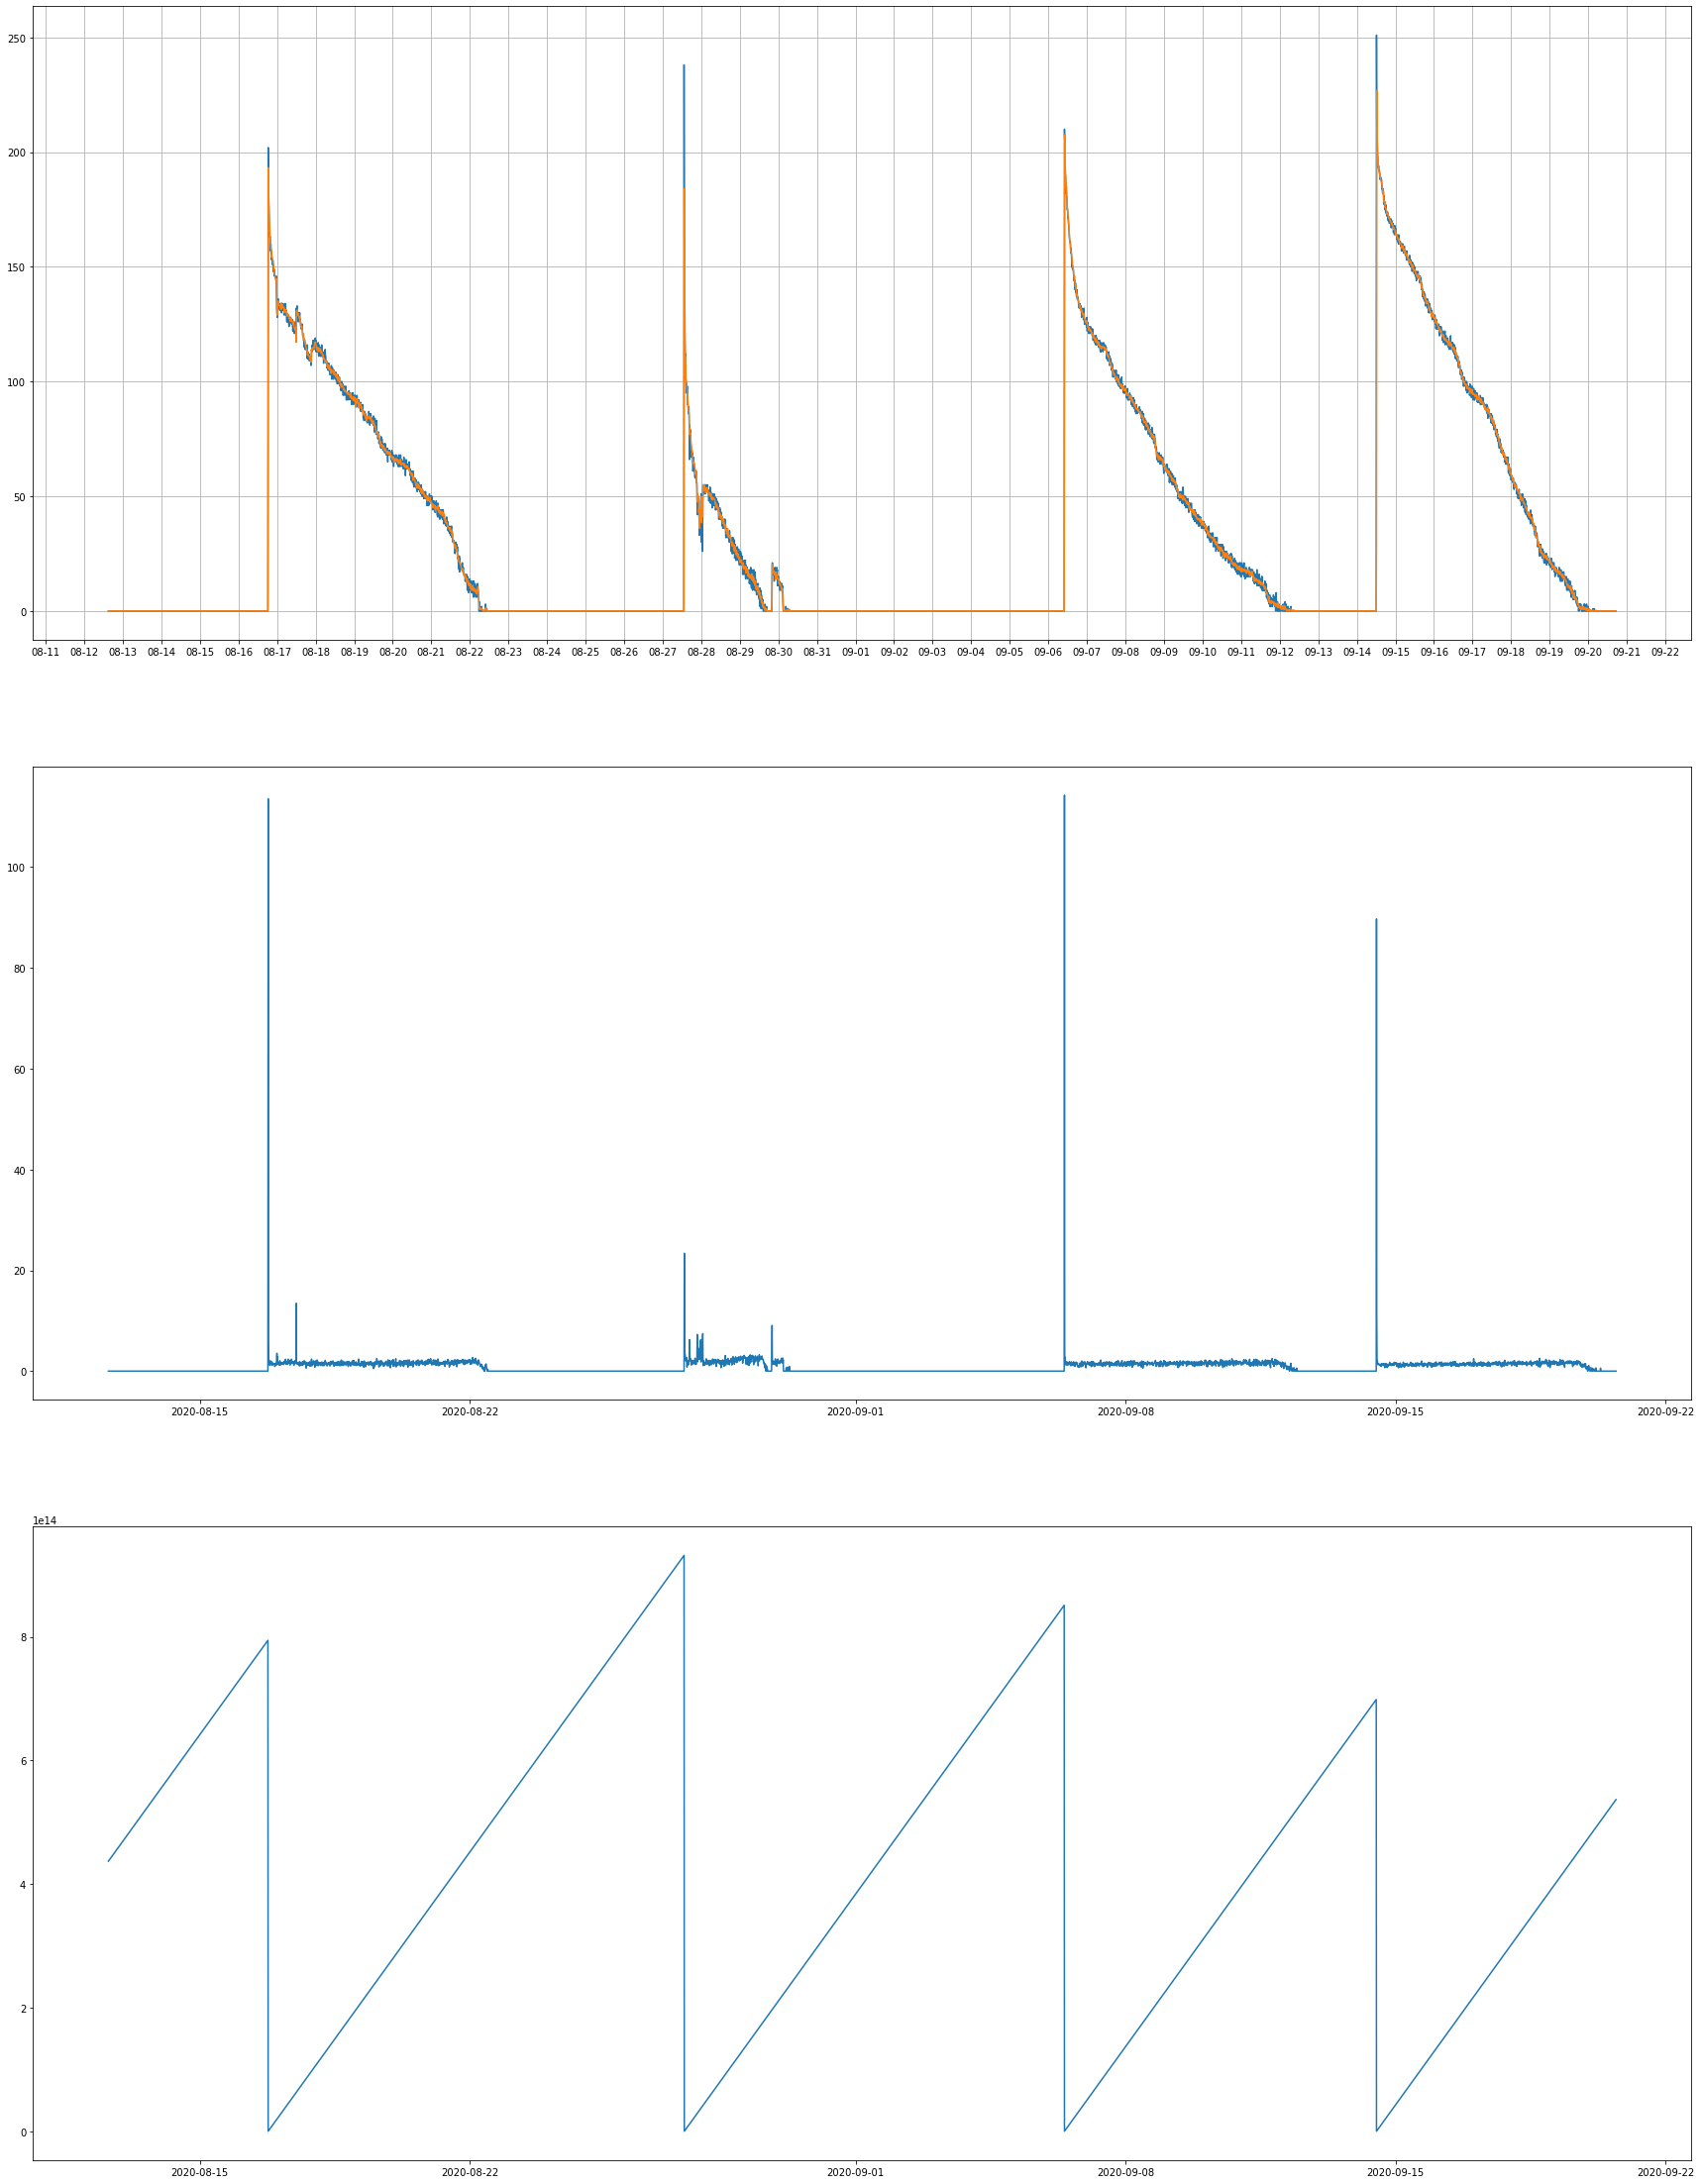

In [77]:
df_ts = df.copy()

fig, ax = plt.subplots(3,figsize=[30,40])
ax[0].grid(True)
ax[0].plot(df_ts.loc[:,'r_sen_2'],label='data')
ax[0].plot(df_ts.loc[:,'avg_sen_2'],label='avgd')
ax[0].xaxis.set_major_locator(mdates.DayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax[1].plot(df_ts['std_sen_2'])
ax[2].plot(df_ts['last_water'])
plt.show()

/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


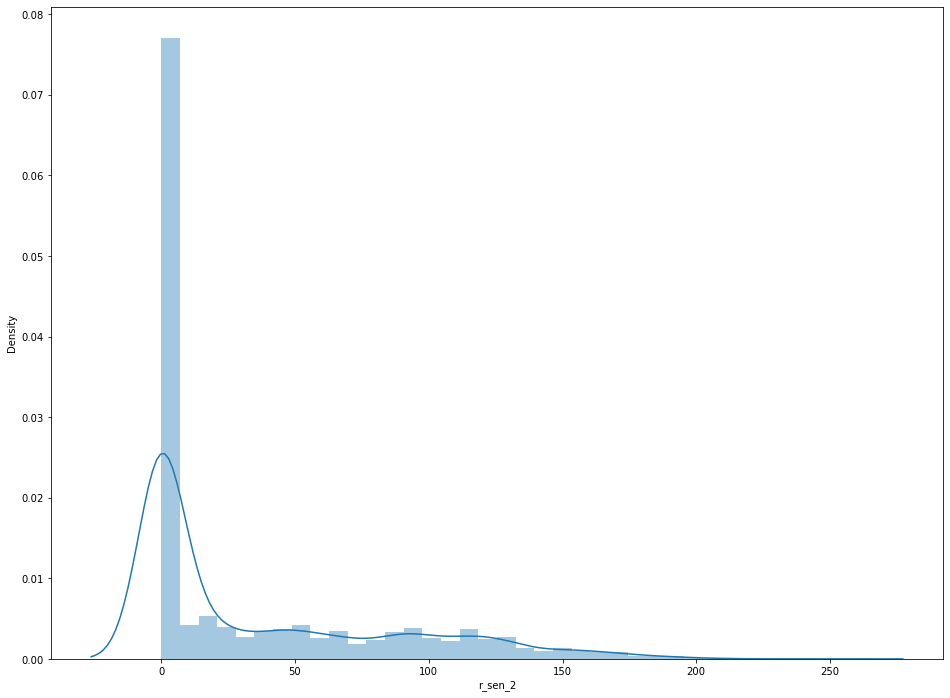

In [78]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df['r_sen_2'], hist=True,ax=ax)
plt.show()

In [79]:
df_t = df.loc[df['std_sen_2'] == 0,:]
df_p = df_t.iloc[::75]
df_p = df_t.loc[df['std_sen_2'].isin(df_p.loc[:,'std_sen_2']),:]
df_t = df.loc[df['std_sen_2'] > 0, :]

df_d = df_p.append(df_t)
df_d.sort_index(inplace=True)

In [80]:
df_d = df_d.reset_index()
df_d.drop(['index'],axis=1,inplace=True)
df_d.to_csv('../notebooks/data/sen_aggre2.csv')

In [81]:
df_d.head()

,datetime,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,2020-08-12 15:02:11,0,0.0,0.0,5 days 01:21:40,2
1,2020-08-12 15:12:11,0,0.0,0.0,5 days 01:31:40,2
2,2020-08-12 15:22:11,0,0.0,0.0,5 days 01:41:40,2
3,2020-08-12 15:32:11,0,0.0,0.0,5 days 01:51:40,2
4,2020-08-12 15:42:11,0,0.0,0.0,5 days 02:01:40,2


/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


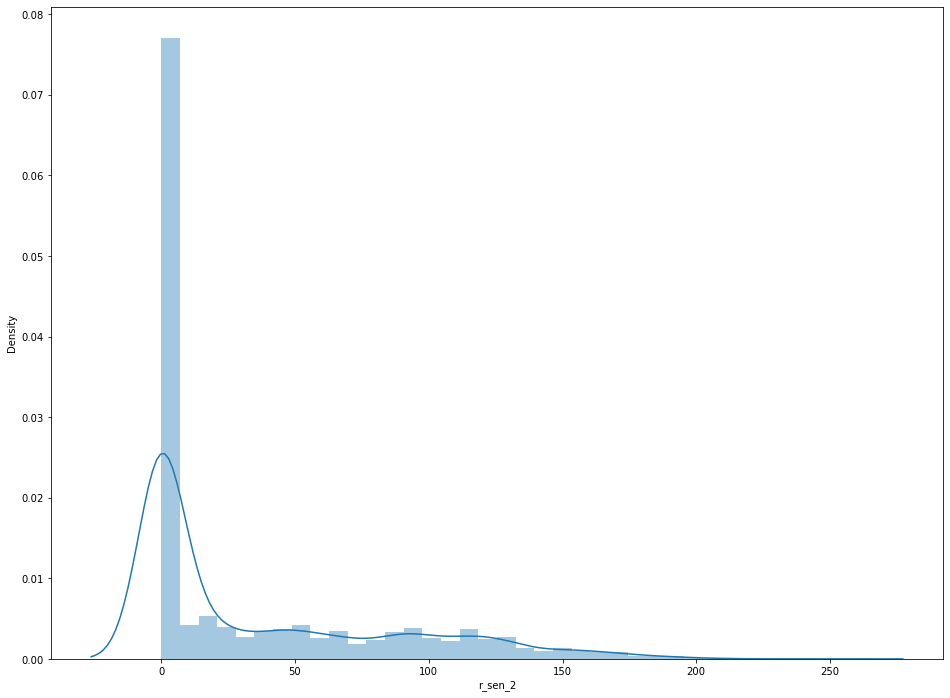

In [82]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df_d['r_sen_2'], hist=True,ax=ax)
plt.show()

## Data processing

In [83]:
def ds_make(df,y_col,win=20,md=False):    
    x, y = [], []
    for i in range(int(len(df)-win-1)):
        a = df.loc[i:(i+win)-1]
        x.append(a)
        if md:
            y.append(df.loc[i+win,['avg_sen_2','std_sen_2']])
        else:
            y.append([df.loc[i+win,'avg_sen_2']])
    return np.array(x), np.array(y)

In [84]:
df_d.drop(['datetime'],axis=1,inplace=True)

df_d.loc[:,'last_water'] = df_d.loc[:,'last_water'].astype(int)/10000000000

#scale down for computing
scaler = MinMaxScaler(feature_range=(0,1))
for col in ['r_sen_2','avg_sen_2','std_sen_2','last_water','dow']:
    df_d.loc[:,col] = scaler.fit_transform(df_d[col].values.reshape(-1,1))

# split into DL data
win = 10
xs, ys = ds_make(df_d,"r_sen_2",win=win)
xs_t = []
for lookback in xs:
    xs_o = []
    for obs in lookback:
        for item in obs:
            xs_o.append(item)
    xs_t.append(xs_o)
    
df_d.head()

,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,0.0,0.0,0.0,0.468908,0.333333
1,0.0,0.0,0.0,0.469552,0.333333
2,0.0,0.0,0.0,0.470196,0.333333
3,0.0,0.0,0.0,0.470840,0.333333
4,0.0,0.0,0.0,0.471483,0.333333


## Data loader

In [85]:
class Dataset(Dataset):
    def __init__(self, data, labels):
#         super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [86]:
trn_x, val_x, trn_y, val_y = train_test_split(xs,ys, test_size=0.2)

In [87]:
trn_ds = Dataset(trn_x, trn_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs)

4498

## Model

In [88]:
class LinBench(nn.Module):
    def __init__(self, thicc, wide, out=1, dense=False):
        super().__init__()
        self.thicc = thicc          #num layers
        self.wide = wide            #num neuron
        self.out = out
        self.dense = dense
        
        self.layers = nn.ModuleList()
    
        for i in range(self.thicc-1):
            self.layers.append(StdLinear(self.wide,self.wide))
        self.layers.append(nn.Linear(self.wide,self.out))
        
    def forward(self, x):
        for i in range(self.thicc):
            x = self.layers[i](x)
        return x

In [33]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10.7}" * len(values)
    values = [epoch,*values] 
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, f'../data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')
names = ["ep / it","trn_loss","val_loss"]
layout = "{!s:10} " * len(names)

In [90]:
net = LinBench(5,win*5)

In [92]:
if use_cuda:
#     [net.cuda() for _,net in nets]
    net.cuda()
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
lr = 2e-4

optim = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.MSELoss()

scheduler = CyclicLR(optim, lr, mode='triangular2', step_size=len(trn_ds)//3)
window = 200

In [65]:
def train(net,epochs):
    t_ls = []
    v_ls = []
    vals = {}
    print(layout.format(*names))
    for epoch in range(epochs):
        trn_it = iter(trn_dl)
        val_it = iter(val_dl)
        for i, (batch, ys) in enumerate(trn_it, 0):
            batch = np.reshape(batch, (-1))
            ys = np.reshape(ys, (-1))
            batch = batch.type(dtype)
            ys = ys.type(dtype)
            
            net.train()
            scheduler.batch_step()
            optim.zero_grad()
            pred = net(batch)
            ls = loss(pred, ys)
            
            ls.backward()
            optim.step()
            
            t_ls.append(ls.item())
            
            if i % window == 0:
                net.eval()
                with torch.no_grad():
                    v_bat, v_ys = next(val_it)
                    v_bat = np.reshape(v_bat,(-1))
                    v_ys = np.reshape(v_ys,(-1))
                    v_bat = v_bat.type(dtype)
                    v_ys = v_ys.type(dtype)
                    
                    v = net(v_bat)
                    v_loss = loss(v, v_ys)
                    v_ls.append(v_loss.item())

                vals[epoch]= [np.mean(t_ls[-window:]), v_ls[-1]]
                print_stats(f'{epoch+1} / {i+1}', vals[epoch], 4)
    return vals, t_ls, v_ls

In [91]:
vals, trn_loss, val_loss = train(net, 5)

ep / it    trn_loss   val_loss   
  1 / 1    0.03409    0.04812   
 1 / 201   0.11944    0.50366   
 1 / 401   0.11247    0.01402   
 1 / 601   0.13399    0.11317   
 1 / 801   0.13494    0.01513   
 1 / 1001  0.13361    0.16828   
 1 / 1201  0.12091    0.25428   
 1 / 1401  0.11367    0.03791   
 1 / 1601  0.13194    0.11293   
 1 / 1801  0.11200    0.01335   
 1 / 2001  0.11086    0.01334   
 1 / 2201  0.10719    0.12116   
 1 / 2401  0.12286    0.01446   
 1 / 2601  0.12286    0.04251   
 1 / 2801  0.12902    0.01466   
 1 / 3001  0.09339    0.01455   
 1 / 3201  0.09582    0.01452   
 1 / 3401  0.11558    0.23984   
 1 / 3601  0.12354    0.01482   
 1 / 3801  0.11493    0.01465   
 1 / 4001  0.14772    0.10242   
 1 / 4201  0.10855    0.01365   
 1 / 4401  0.10946    0.01478   
  2 / 1    0.11474    0.04812   
 2 / 201   0.11461    0.50366   
 2 / 401   0.12668    0.01402   
 2 / 601   0.10723    0.11317   
 2 / 801   0.12131    0.01513   
 2 / 1001  0.10440    0.16828   
 2 / 1201

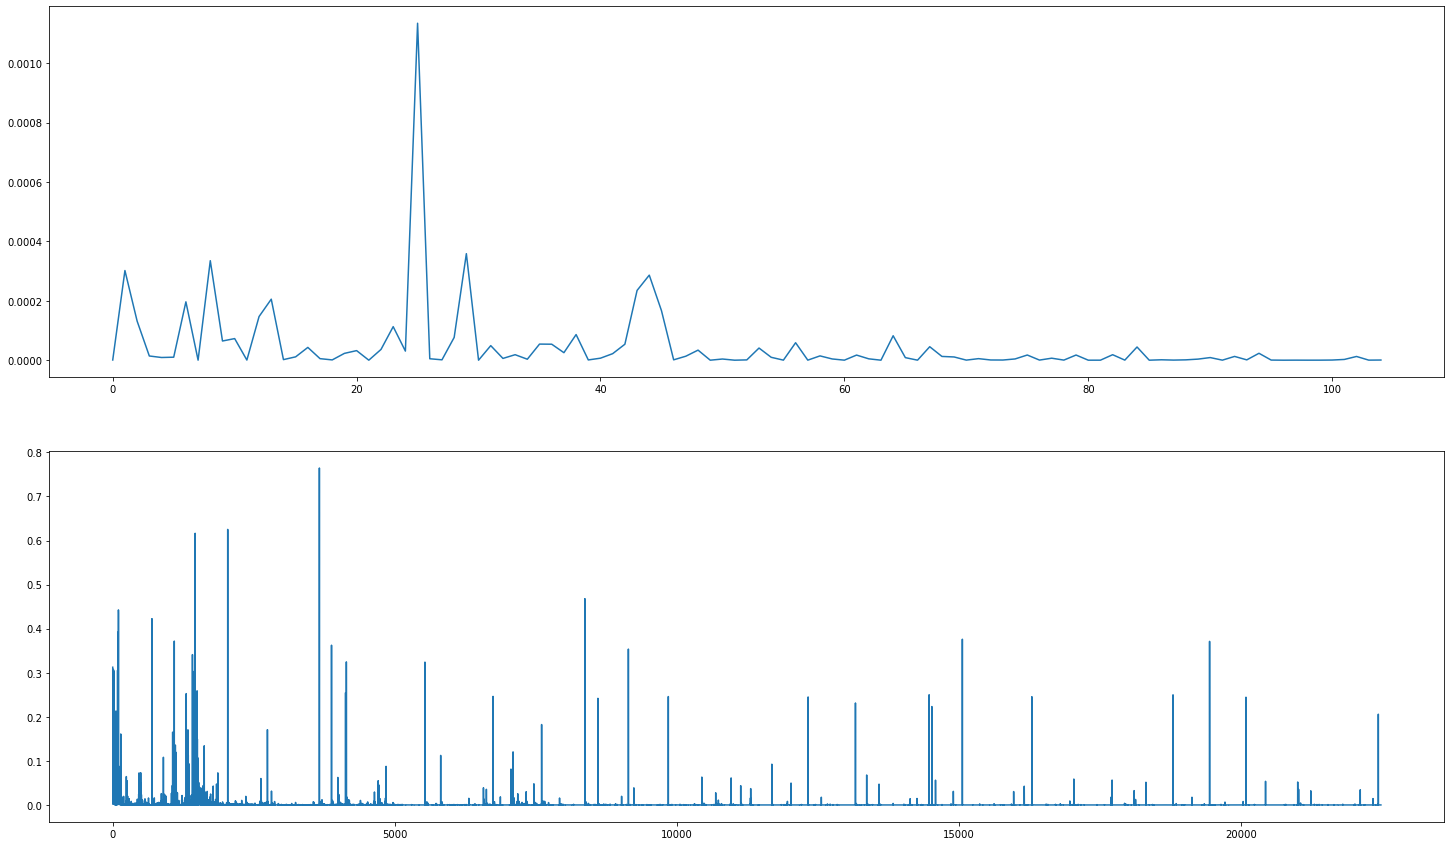

In [67]:
fig, ax = plt.subplots(2,figsize=[25,15])
# [ax[i].grid(True) for i in ax]
ax[0].plot(val_loss[10:],label='preds')
ax[1].plot(trn_loss[10:],label='train')
plt.show()

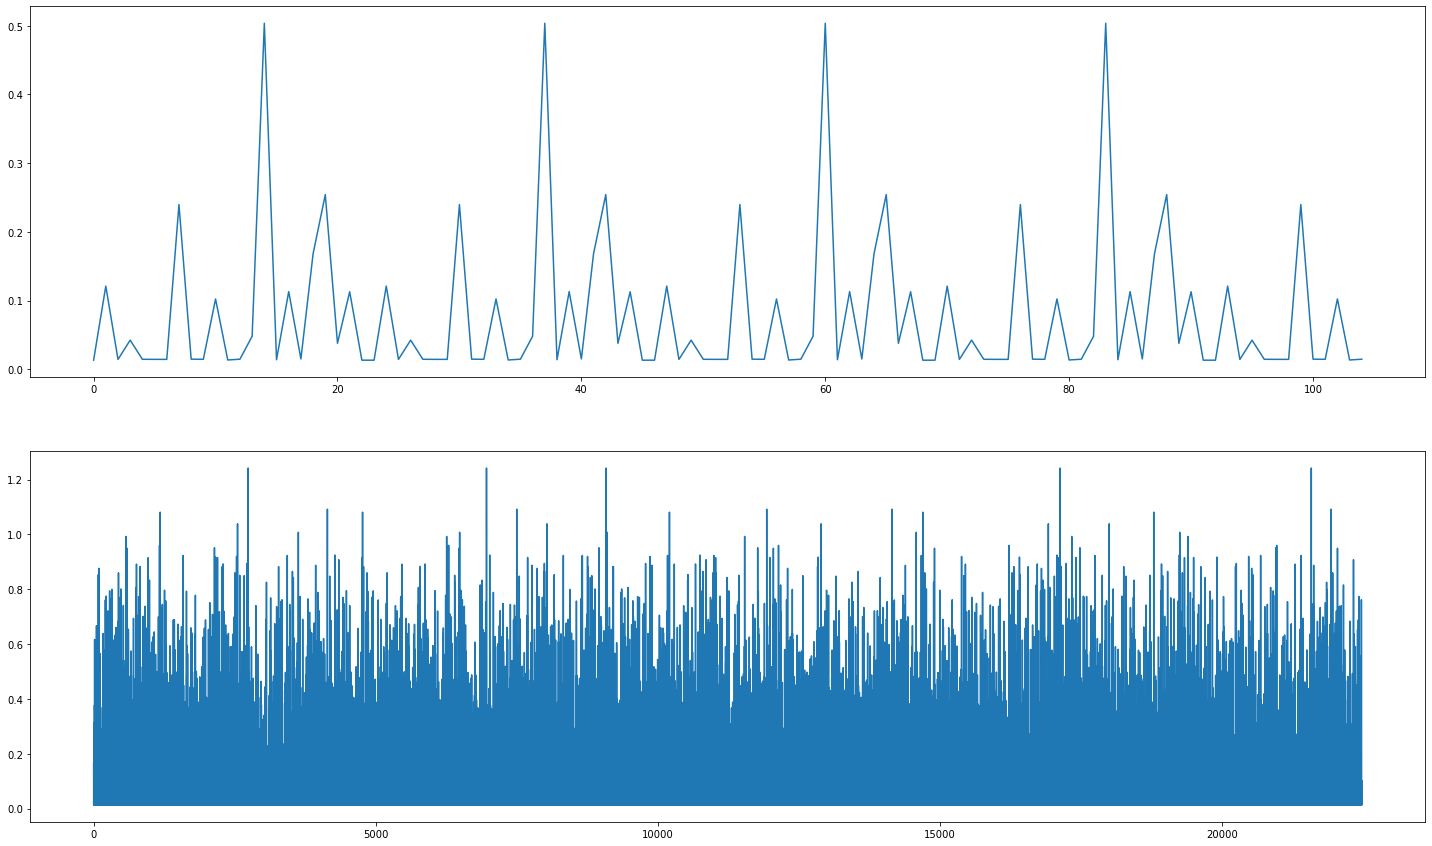

In [93]:
fig, ax = plt.subplots(2,figsize=[25,15])
# [ax[i].grid(True) for i in ax]
ax[0].plot(val_loss[10:],label='preds')
ax[1].plot(trn_loss[10:],label='train')
plt.show()

In [29]:
trn_it = iter(trn_dl)
batch, ys = next(trn_it)
batch = np.reshape(batch,(-1))
batch = batch.type(dtype)
ys = ys.type(dtype)
pred = net(batch)
print(pred)
print(ys)

tensor([0.0088], grad_fn=<AddBackward0>)
tensor([[0.]])


In [30]:
val_it = iter(val_dl)
v = []
v_ys = []
net.eval()
for batch in range(len(val_dl)//bs):
    with torch.no_grad():
        v_bat, v_y = next(val_it)
        v_bat = np.reshape(v_bat,(-1))
        v_y = np.reshape(v_y,(-1))
        v_bat = v_bat.type(dtype)

        v.append(net(v_bat).item())
        v_ys.append(v_y)

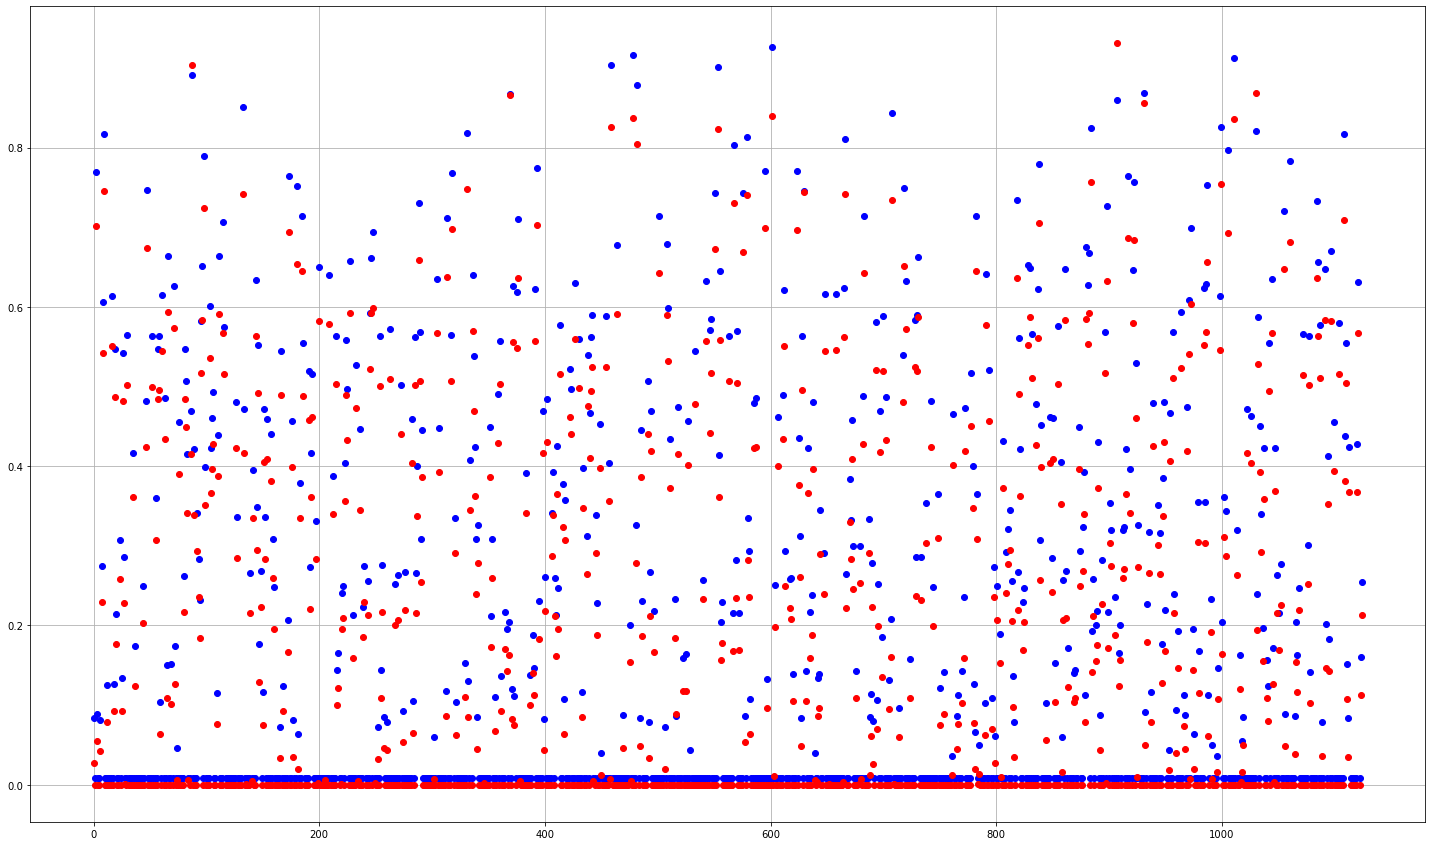

In [31]:
fig, ax = plt.subplots(figsize=[25,15])
ax.grid(True)
ax.plot(v,'bo',label='preds')
ax.plot(v_ys,'ro',label='truth')
plt.show()

Reference


https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205